In [1]:
nombre = "\nMadrigal Urencio Ricardo\n"

In [2]:
dir_hdfs = "hdfs://namenode:9000/tmp/amd/locatellimpio"

df = spark.read.csv(dir_hdfs, header = True, inferSchema = True)

print(nombre)
df.printSchema()

df.createOrReplaceTempView("locatel")
spark.sql("show tables").show()


Madrigal Urencio Ricardo

root
 |-- fecha_solicitud: date (nullable = true)
 |-- hora_solicitud: timestamp (nullable = true)
 |-- tema_solicitud: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- edad: double (nullable = true)
 |-- estatus: string (nullable = true)
 |-- alcaldia: string (nullable = true)
 |-- colonia_datos: string (nullable = true)
 |-- latitud: double (nullable = true)
 |-- longitud: double (nullable = true)
 |-- codigo_postal_solicitud: string (nullable = true)
 |-- d_codigo: integer (nullable = true)
 |-- D_mnpio: string (nullable = true)

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |  locatel|       true|
+---------+---------+-----------+



In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
 
schema = StructType([
    StructField("d_codigo", StringType(), True),
    StructField("d_asenta", StringType(), True),
    StructField("d_tipo_asenta", StringType(), True),
    StructField("D_mnpio", StringType(), True),
    StructField("d_estado", StringType(), True),
    StructField("d_ciudad", StringType(), True),
    StructField("d_CP", StringType(), True),
    StructField("c_estado", StringType(), True),
    StructField("c_oficina", StringType(), True),
    StructField("c_CP", StringType(), True),
    StructField("c_tipo_asenta", StringType(), True),
    StructField("c_mnpio", StringType(), True),
    StructField("id_asenta_cpcons", StringType(), True),
    StructField("d_zona", StringType(), True),
    StructField("c_cve_ciudad", StringType(), True)
])

sepomex_df = spark.read\
            .option("header","true")\
            .option("delimiter", "|")\
            .option("skipRows", "1")\
            .option("encoding", "UTF-8")\
            .schema(schema)\
            .csv("hdfs://namenode:9000/tmp/amd/sepomex/")

sepomex_df.count()
sepomex_df.select(['d_codigo', 'D_mnpio', 'd_estado', 'd_ciudad']).distinct().createOrReplaceTempView("sepomex")
spark.sql("show tables").show()


+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |  locatel|       true|
|         |  sepomex|       true|
+---------+---------+-----------+



In [4]:
#Estadísticas específicas de un solo campo

sqlstr = """
select min(edad) as min_edad, max(edad) as max_edad, avg(edad) as avg_edad,
stddev(edad) as stddev_edad, count(edad) nr,
percentile_cont(0.5) within group (order by edad) as mediana_edad
from locatel
"""

spark.sql(sqlstr).show()

+--------+--------+-----------------+------------------+------+------------+
|min_edad|max_edad|         avg_edad|       stddev_edad|    nr|mediana_edad|
+--------+--------+-----------------+------------------+------+------------+
|     0.0| 16090.0|39.27146399881764|27.238747481977125|920192|        43.0|
+--------+--------+-----------------+------------------+------+------------+



In [5]:
spark.sql("select count(*) from locatel").show()

+--------+
|count(1)|
+--------+
| 2323089|
+--------+



In [6]:
sqlstr = """
select edad, count(*) nr 
from locatel 
group by edad 
order by edad desc
"""

spark.sql(sqlstr).show(20)

+-------+---+
|   edad| nr|
+-------+---+
|16090.0|  1|
|  100.0| 16|
|   99.0| 19|
|   98.0| 14|
|   97.0| 23|
|   96.0| 26|
|   95.0| 36|
|   94.0| 51|
|   93.0| 77|
|   92.0| 89|
|   91.0|109|
|   90.0|205|
|   89.0|212|
|   88.0|288|
|   87.0|377|
|   86.0|483|
|   85.0|698|
|   84.0|714|
|   83.0|847|
|   82.0|980|
+-------+---+
only showing top 20 rows



In [7]:
from pyspark.sql.functions import col, when, avg
edad_promedio = df.filter(col("edad") != 16090.0).agg(avg("edad")).first()[0]
edad_promedio

39.25402117603845

In [8]:
#Reemplazar el valor 16090 por la edad promedio
df = df.withColumn(
    "edad", when(col("edad") == 16090.0, edad_promedio).otherwise(col("edad"))
    )
df.createOrReplaceTempView("locatel")

In [9]:
#Estadísticas específicas de un solo campo

sqlstr = """
select min(edad) as min_edad, max(edad) as max_edad, avg(edad) as avg_edad,
stddev(edad) as stddev_edad, count(edad) nr,
percentile_cont(0.5) within group (order by edad) as mediana_edad
from locatel
"""

spark.sql(sqlstr).show()

+--------+--------+-----------------+-----------------+------+------------+
|min_edad|max_edad|         avg_edad|      stddev_edad|    nr|mediana_edad|
+--------+--------+-----------------+-----------------+------+------------+
|     0.0|   100.0|39.25402117603845|21.49369783924046|920192|        43.0|
+--------+--------+-----------------+-----------------+------+------------+



In [10]:
import matplotlib.pyplot as plt
df_edad = spark.sql("select edad from locatel where edad is not null")\
          .toPandas()

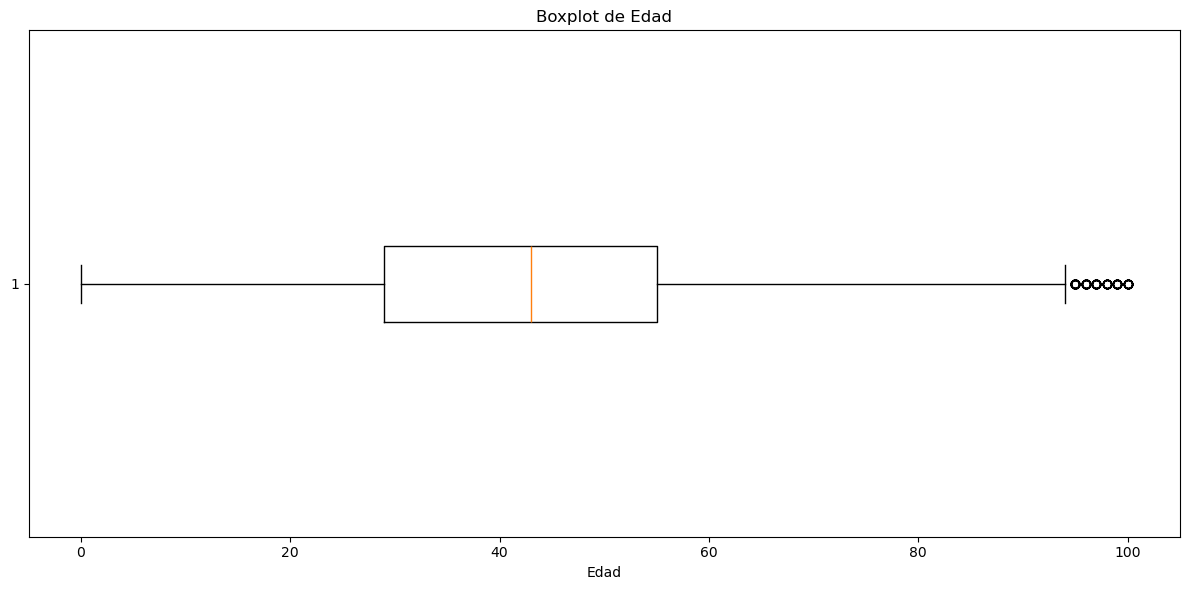

In [11]:
#Crear grafica de bocplot para edad
plt.figure(figsize=(12,6))
plt.boxplot(df_edad['edad'], vert = False)

plt.title("Boxplot de Edad")
plt.xlabel("Edad")

plt.tight_layout()
plt.show()

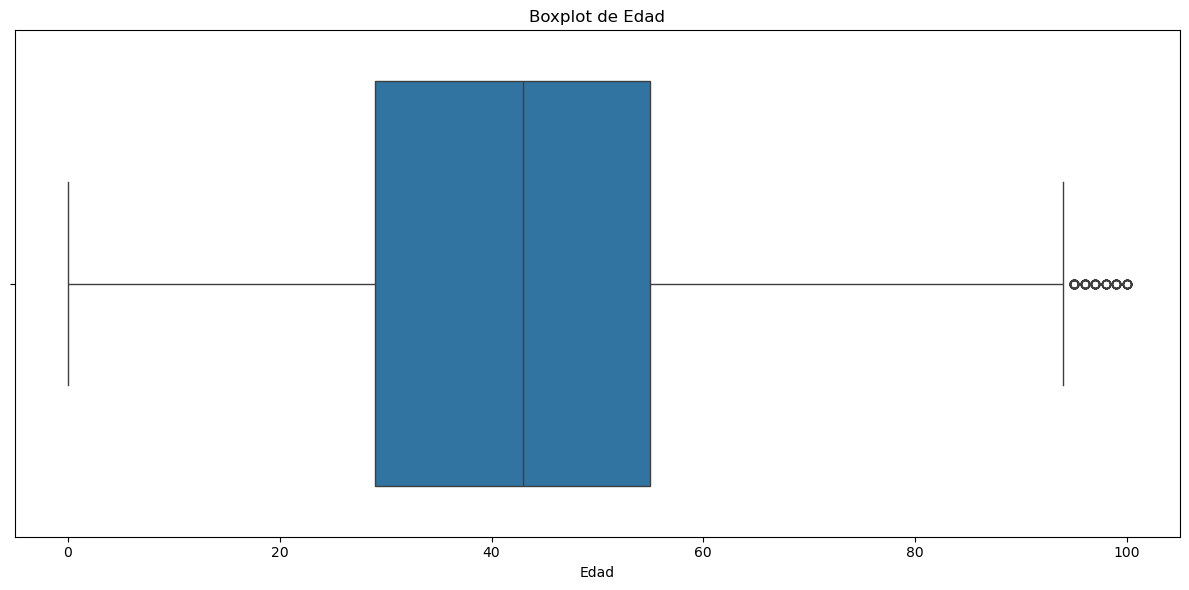

In [12]:
#Crear grafica de seaborn para edad
import seaborn as sns

plt.figure(figsize=(12,6))
#plt.boxplot(df_edad['edad'], vert = False)
sns.boxplot(df_edad['edad'], orient = 'h')

plt.title("Boxplot de Edad")
plt.xlabel("Edad")

plt.tight_layout()
plt.show()

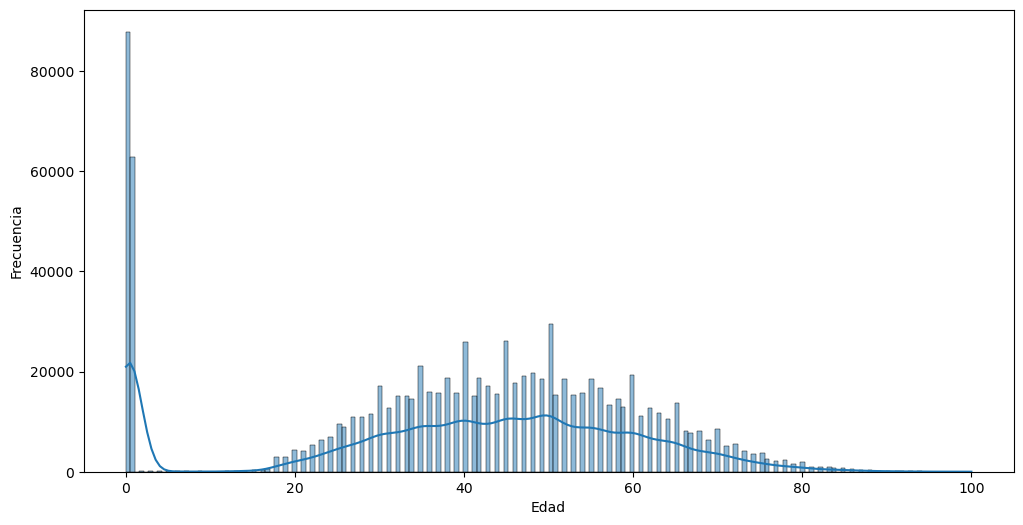

In [13]:
plt.figure(figsize=(12,6))
sns.histplot(data = df_edad, x = "edad", kde = True)
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

In [14]:
#Ver datos por estado

sqlstr = """
select d_estado, count(*) nr
from locatel l
left join sepomex s
on(l.d_codigo = s.d_codigo)
group by d_estado
order by 1
"""

spark.sql(sqlstr).show()

+--------------------+-------+
|            d_estado|     nr|
+--------------------+-------+
|                NULL| 297202|
|      Aguascalientes|     44|
|     Baja California|     73|
| Baja California Sur|     22|
|            Campeche|     17|
|             Chiapas|     70|
|           Chihuahua|     53|
|    Ciudad de México|2019363|
|Coahuila de Zaragoza|     53|
|              Colima|     30|
|             Durango|     17|
|          Guanajuato|    153|
|            Guerrero|     87|
|             Hidalgo|    112|
|             Jalisco|    220|
| Michoacán de Ocampo|    100|
|             Morelos|    144|
|              México|   4122|
|             Nayarit|     29|
|          Nuevo León|    150|
+--------------------+-------+
only showing top 20 rows



In [15]:
sqlstr = """
select d_estado, count(*) nr
from locatel l
left join sepomex s
on(l.d_codigo = s.d_codigo)
group by d_estado
having nr <= 100
order by 2 desc, 1 asc
"""

spark.sql(sqlstr).show()

+--------------------+---+
|            d_estado| nr|
+--------------------+---+
| Michoacán de Ocampo|100|
|            Guerrero| 87|
|     Baja California| 73|
|             Chiapas| 70|
|              Oaxaca| 68|
|     San Luis Potosí| 65|
|        Quintana Roo| 62|
|          Tamaulipas| 54|
|           Chihuahua| 53|
|Coahuila de Zaragoza| 53|
|              Sonora| 53|
|             Tabasco| 53|
|      Aguascalientes| 44|
|             Yucatán| 43|
|             Sinaloa| 40|
|            Tlaxcala| 36|
|              Colima| 30|
|           Zacatecas| 30|
|             Nayarit| 29|
| Baja California Sur| 22|
+--------------------+---+
only showing top 20 rows



In [16]:
sqlstr = """
select d_estado, count(*) nr
from locatel l
left join sepomex s
on(l.d_codigo = s.d_codigo)
group by d_estado
order by 2 desc
limit 5
"""

spark.sql(sqlstr).show()

+----------------+-------+
|        d_estado|     nr|
+----------------+-------+
|Ciudad de México|2019363|
|            NULL| 297202|
|          México|   4122|
|         Jalisco|    220|
|       Querétaro|    213|
+----------------+-------+



In [17]:
#Ver datos por ciudad

sqlstr = """
select s.d_ciudad, count(*) nr
from locatel l
left join sepomex s
on(l.d_codigo = s.d_codigo)
group by s.d_ciudad
order by 2 desc, 1 asc
"""

spark.sql(sqlstr).show(40, truncate = False)

+-----------------------------+-------+
|d_ciudad                     |nr     |
+-----------------------------+-------+
|Ciudad de México             |2018712|
|NULL                         |298752 |
|Ciudad Nezahualcóyotl        |585    |
|Ecatepec de Morelos          |560    |
|Tlalnepantla de Baz          |470    |
|Naucalpan de Juárez          |445    |
|Huixquilucan de Degollado    |276    |
|Ciudad Adolfo López Mateos   |188    |
|Cuautitlán Izcalli           |156    |
|Ixtapaluca                   |127    |
|Tultitlán de Mariano Escobedo|120    |
|Chimalhuacán                 |114    |
|Tecámac de Felipe Villanueva |107    |
|Heroica Puebla de Zaragoza   |105    |
|Santiago de Querétaro        |102    |
|Valle de Chalco Solidaridad  |101    |
|Cuernavaca                   |73     |
|Chalco de Díaz Covarrubias   |69     |
|Monterrey                    |69     |
|Los Reyes Acaquilpan (La Paz)|67     |
|Ciudad Nicolás Romero        |64     |
|León de los Aldama           |64     |


In [18]:
#Ver registros que no sean de CDMX o Nulos

sqlstr = """
select count(*) nr
from locatel l
left join sepomex s
on(l.d_codigo = s.d_codigo)
where s.d_ciudad is not null and s.d_ciudad != "Ciudad de México"
"""

spark.sql(sqlstr).show(40, truncate = False)

+----+
|nr  |
+----+
|5728|
+----+



In [19]:
#Ver datos por municipio

sqlstr = """
select s.d_estado, s.d_ciudad, s.D_mnpio, count(*) nr
from locatel l
left join sepomex s
on(l.d_codigo = s.d_codigo)
where s.d_estado in("Ciudad de México", "México")
group by s.d_estado, s.d_ciudad, s.D_mnpio
order by s.d_estado, s.d_ciudad, s.D_mnpio
"""

spark.sql(sqlstr).show(100, truncate = False)

+----------------+--------------------------+---------------------------+------+
|d_estado        |d_ciudad                  |D_mnpio                    |nr    |
+----------------+--------------------------+---------------------------+------+
|Ciudad de México|NULL                      |La Magdalena Contreras     |651   |
|Ciudad de México|Ciudad de México          |Azcapotzalco               |198806|
|Ciudad de México|Ciudad de México          |Benito Juárez              |90308 |
|Ciudad de México|Ciudad de México          |Coyoacán                   |267112|
|Ciudad de México|Ciudad de México          |Cuajimalpa de Morelos      |22686 |
|Ciudad de México|Ciudad de México          |Cuauhtémoc                 |187244|
|Ciudad de México|Ciudad de México          |Gustavo A. Madero          |203191|
|Ciudad de México|Ciudad de México          |Iztacalco                  |130684|
|Ciudad de México|Ciudad de México          |Iztapalapa                 |151029|
|Ciudad de México|Ciudad de 

In [20]:
#Remplazar Nulos con 'No Disponible'
sqlstr = """
select coalesce(nullif(trim(s.d_ciudad), ''), 'No Disponible') as ciudad, count(*) nr
from locatel l
left join sepomex s
on(l.d_codigo = s.d_codigo)
where s.d_estado in("Ciudad de México", "México")
group by ciudad
order by nr desc, ciudad
"""

spark.sql(sqlstr).show(100, truncate = False)

+---------------------------------+-------+
|ciudad                           |nr     |
+---------------------------------+-------+
|Ciudad de México                 |2018712|
|No Disponible                    |955    |
|Ciudad Nezahualcóyotl            |585    |
|Ecatepec de Morelos              |560    |
|Tlalnepantla de Baz              |470    |
|Naucalpan de Juárez              |445    |
|Huixquilucan de Degollado        |276    |
|Ciudad Adolfo López Mateos       |188    |
|Cuautitlán Izcalli               |156    |
|Ixtapaluca                       |127    |
|Tultitlán de Mariano Escobedo    |120    |
|Chimalhuacán                     |114    |
|Tecámac de Felipe Villanueva     |107    |
|Valle de Chalco Solidaridad      |101    |
|Chalco de Díaz Covarrubias       |69     |
|Los Reyes Acaquilpan (La Paz)    |67     |
|Ciudad Nicolás Romero            |64     |
|Coacalco de Berriozabal          |62     |
|Cuautitlán                       |57     |
|Chicoloapan de Juárez          

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'No Disponible'),
  Text(1, 0, 'Ciudad Nezahualcóyotl'),
  Text(2, 0, 'Ecatepec de Morelos'),
  Text(3, 0, 'Tlalnepantla de Baz'),
  Text(4, 0, 'Naucalpan de Juárez'),
  Text(5, 0, 'Huixquilucan de Degollado'),
  Text(6, 0, 'Ciudad Adolfo López Mateos'),
  Text(7, 0, 'Cuautitlán Izcalli'),
  Text(8, 0, 'Ixtapaluca'),
  Text(9, 0, 'Tultitlán de Mariano Escobedo')])

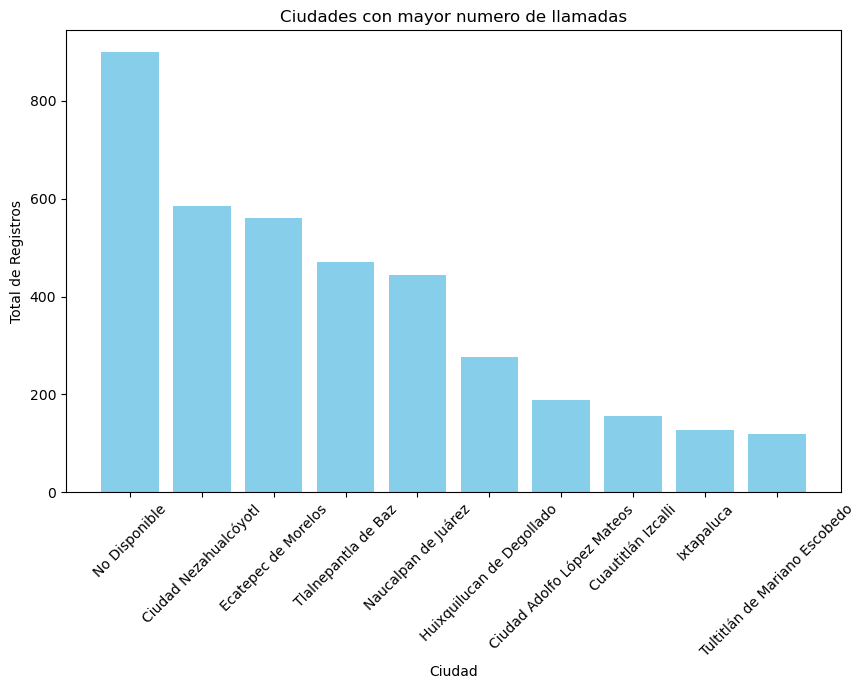

In [21]:
#Generar un Pandas

sqlstr = """
select coalesce(nullif(trim(s.d_ciudad), ''), 'No Disponible') as ciudad, count(*) nr
from locatel l
left join sepomex s
on(l.d_codigo = s.d_codigo)
where s.d_estado not in("Ciudad de México")
group by ciudad
order by nr desc, ciudad
limit 10
"""

df_pandas = spark.sql(sqlstr).toPandas()

plt.figure(figsize = (10, 6))
plt.bar(df_pandas['ciudad'], df_pandas['nr'], color = 'skyblue')
plt.xlabel('Ciudad')
plt.ylabel('Total de Registros')
plt.title('Ciudades con mayor numero de llamadas')
plt.xticks(rotation = 45)

In [22]:
#Agrupar todo lo que no tenga Estado en 'Otro'

sqlstr = """
select 
    case when d_estado is not null and d_estado != 'Ciudad de México'
    then municipio else 'Otro' end as municipio, 
    sum(case when d_estado is not null and d_estado != 'Ciudad de México' then nr else 0 end) as nr

from(
    select d_estado, coalesce(nullif(trim(s.D_mnpio), ''), 'No Disponible') as municipio, count(*) nr
    from locatel l
    left join sepomex s
    on(l.d_codigo = s.d_codigo)
    group by d_estado, municipio
    ) x
group by d_estado, municipio
order by nr desc
limit 10
"""

spark.sql(sqlstr).show(truncate = False)

+--------------------+---+
|municipio           |nr |
+--------------------+---+
|Nezahualcóyotl      |585|
|Ecatepec de Morelos |560|
|Tlalnepantla de Baz |470|
|Naucalpan de Juárez |464|
|Huixquilucan        |276|
|Atizapán de Zaragoza|188|
|Cuautitlán Izcalli  |156|
|Querétaro           |127|
|Ixtapaluca          |127|
|Tultitlán           |120|
+--------------------+---+



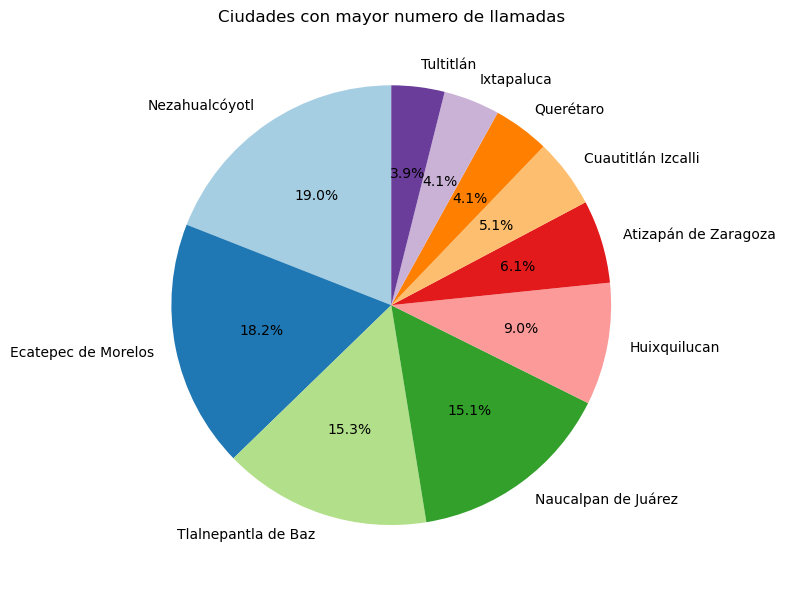

In [23]:
#Generar un Pandas de los estdos
sqlstr = """
select 
    case when d_estado is not null and d_estado != 'Ciudad de México'
    then municipio else 'Otro' end as municipio, 
    sum(case when d_estado is not null and d_estado != 'Ciudad de México' then nr else 0 end) as nr

from(
    select d_estado, coalesce(nullif(trim(s.D_mnpio), ''), 'No Disponible') as municipio, count(*) nr
    from locatel l
    left join sepomex s
    on(l.d_codigo = s.d_codigo)
    group by d_estado, municipio
    ) x
group by d_estado, municipio
order by nr desc
limit 10
"""

df_pandas = spark.sql(sqlstr).toPandas()

plt.figure(figsize = (10, 6))
plt.pie(df_pandas['nr'], labels = df_pandas['municipio'], autopct = '%1.1f%%', startangle = 90, colors = plt.cm.Paired.colors)

plt.title('Ciudades con mayor numero de llamadas')
plt.tight_layout()
plt.show()

In [28]:
import seaborn as sns
sns.set(style='whitegrid')
sqlstr = """
select coalesce(nullif(trim(s.D_mnpio), ''), 'No Disponible') as municipio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
group by municipio
order by nr desc
"""
df_pandas = spark.sql(sqlstr).toPandas()
df_pandas

,municipio,nr
0,Coyoacán,267112
1,Gustavo A. Madero,203191
2,Azcapotzalco,198806
3,Cuauhtémoc,187249
4,Xochimilco,166157
...,...,...
567,Penjamillo,1
568,González,1
569,San Pablo Etla,1
570,Loreto,1


In [30]:
df_pandas = spark.sql(sqlstr).toPandas()
umbral = 1000
df_pandas.loc[df_pandas['nr'] < umbral, 'municipio'] = 'Otros'
df_grouped = df_pandas.groupby('municipio').sum().reset_index()
df_grouped

,municipio,nr
0,Azcapotzalco,198806
1,Benito Juárez,90342
2,Coyoacán,267112
3,Cuajimalpa de Morelos,22686
4,Cuauhtémoc,187249
5,Gustavo A. Madero,203191
6,Iztacalco,130684
7,Iztapalapa,151029
8,La Magdalena Contreras,16827
9,Miguel Hidalgo,153903


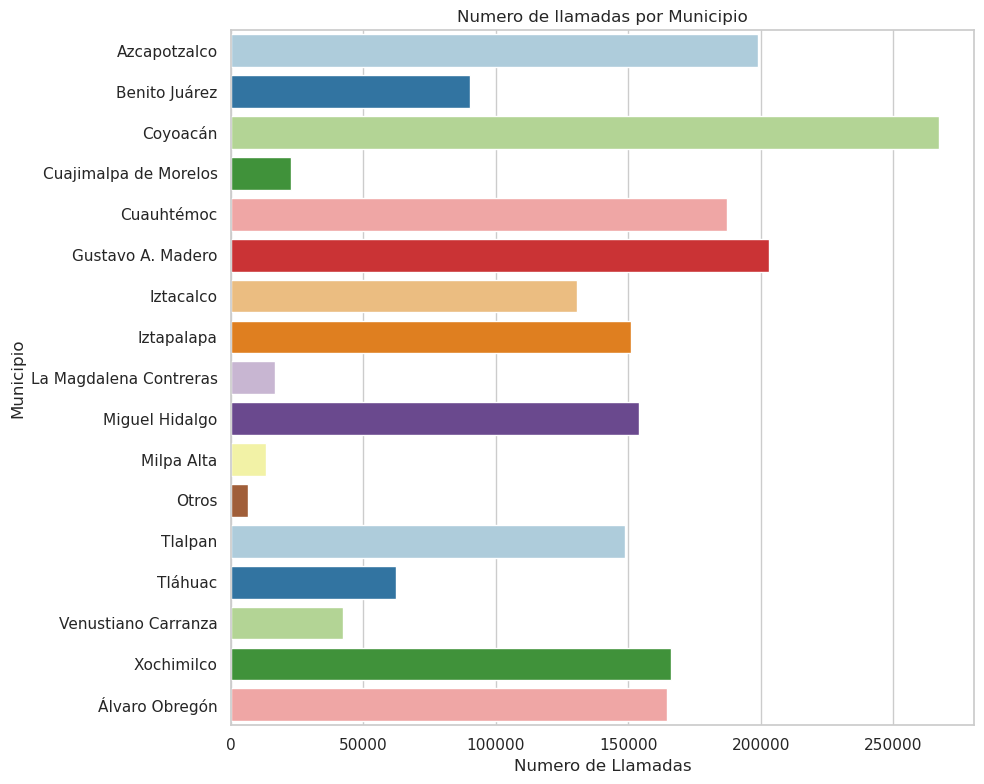

In [33]:
import seaborn as sns
sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 8))
sns.barplot(x = 'nr', y = 'municipio', data = df_grouped, palette = 'Paired', hue = 'municipio')

plt.title('Numero de llamadas por Municipio')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Municipio')
plt.tight_layout()
plt.show()

In [36]:
sns.set(style='whitegrid')
sqlstr = """
select  year(l.fecha_solicitud) as anio, avg(hour(l.hora_solicitud)) as hora_promedio, avg(l.edad) as edad_promedio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
group by anio
order by anio 
"""
df_pandas = spark.sql(sqlstr).toPandas()
df_pandas

,anio,hora_promedio,edad_promedio,nr
0,2019,13.106716,47.455391,184667
1,2020,13.759313,39.954872,309572
2,2021,14.158502,42.699276,466386
3,2022,13.412501,30.790273,472248
4,2023,13.150109,45.297334,511702
5,2024,12.688890,50.814839,81415


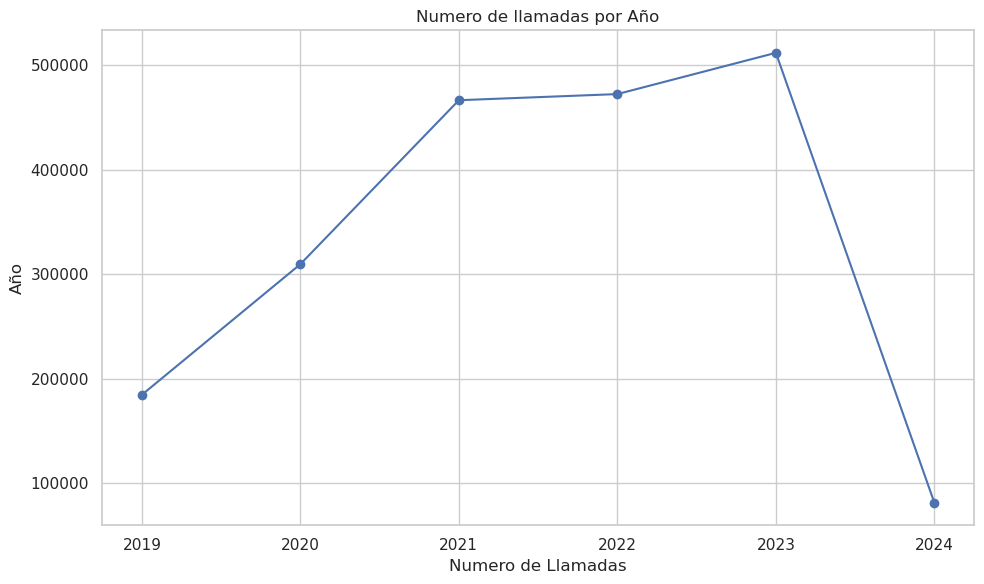

In [38]:
plt.figure(figsize = (10, 6))
plt.plot(df_pandas['anio'], df_pandas['nr'], marker = 'o', linestyle = '-', color = 'b')

plt.title('Numero de llamadas por Año')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Año')
plt.tight_layout()
plt.show()

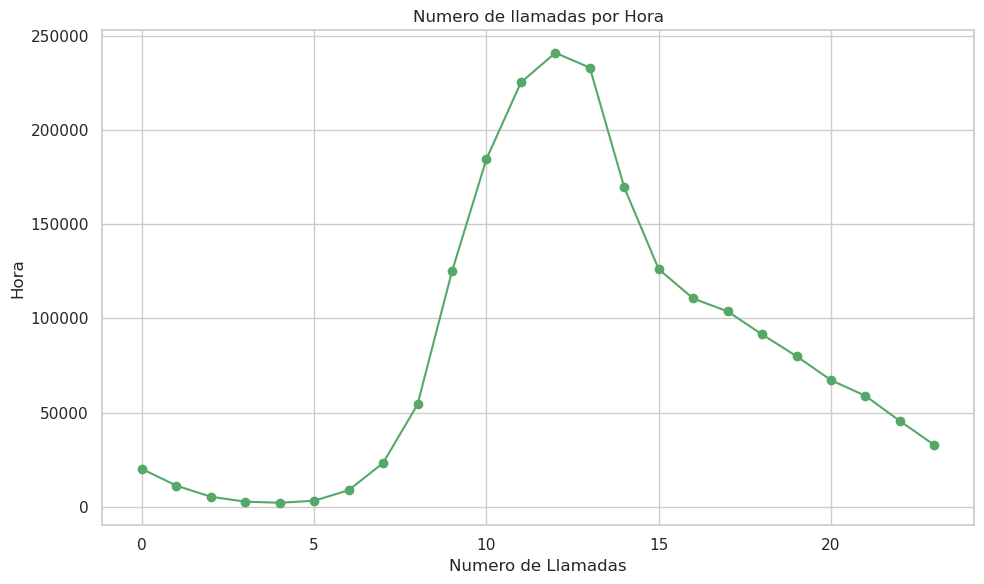

In [48]:
sns.set(style='whitegrid')
sqlstr = """
select  hour(l.hora_solicitud) as hora, avg(l.edad) as edad_promedio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
group by hora
order by hora 
"""
df_pandas = spark.sql(sqlstr).toPandas()
plt.figure(figsize = (10, 6))
plt.plot(df_pandas['hora'], df_pandas['nr'], marker = 'o', linestyle = '-', color = 'g')

plt.title('Numero de llamadas por Hora')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Hora')
plt.tight_layout()
plt.show()

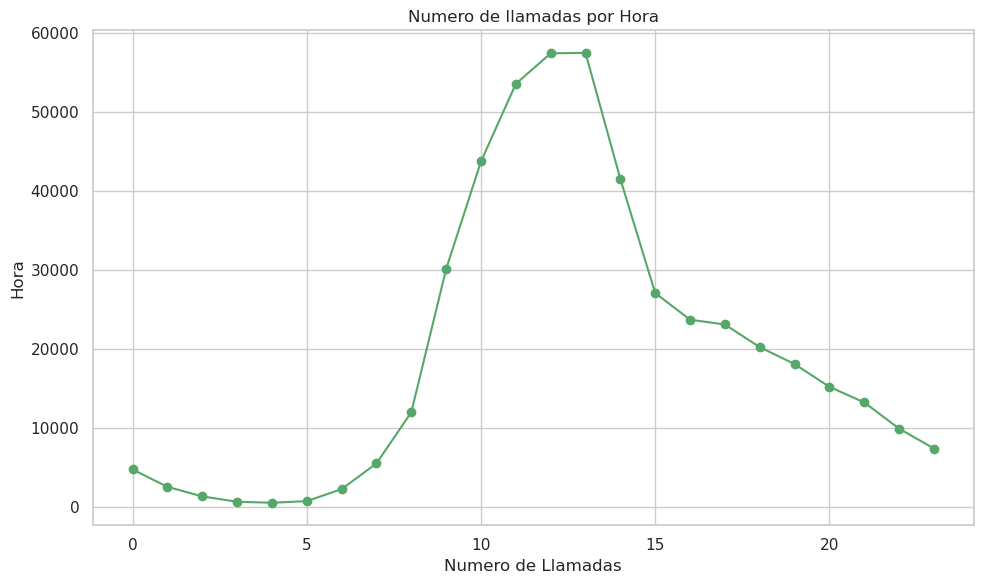

In [54]:
sns.set(style='whitegrid')
sqlstr = """
select  hour(l.hora_solicitud) as hora, avg(l.edad) as edad_promedio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
where year(fecha_solicitud) = 2022
group by hora
order by hora 
"""
df_pandas = spark.sql(sqlstr).toPandas()
plt.figure(figsize = (10, 6))
plt.plot(df_pandas['hora'], df_pandas['nr'], marker = 'o', linestyle = '-', color = 'g')

plt.title('Numero de llamadas por Hora')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Hora')
plt.tight_layout()
plt.show()

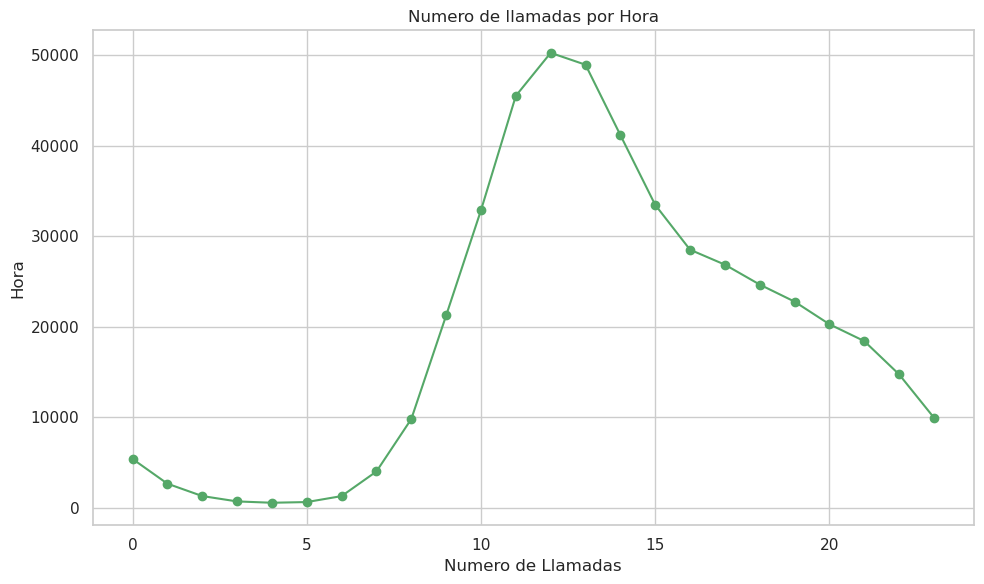

In [55]:
sns.set(style='whitegrid')
sqlstr = """
select  hour(l.hora_solicitud) as hora, avg(l.edad) as edad_promedio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
where year(fecha_solicitud) = 2021
group by hora
order by hora 
"""
df_pandas = spark.sql(sqlstr).toPandas()
plt.figure(figsize = (10, 6))
plt.plot(df_pandas['hora'], df_pandas['nr'], marker = 'o', linestyle = '-', color = 'g')

plt.title('Numero de llamadas por Hora')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Hora')
plt.tight_layout()
plt.show()

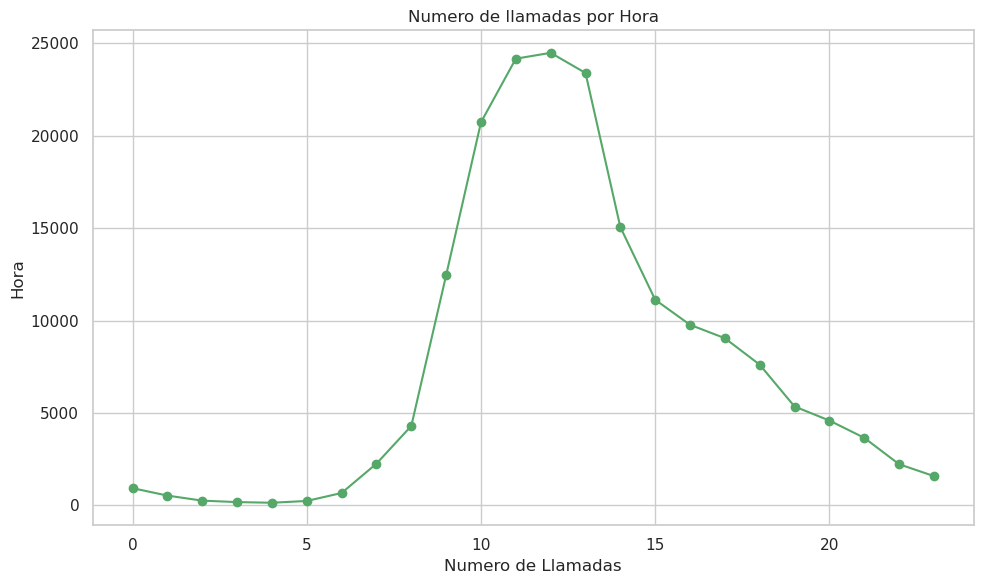

In [56]:
sns.set(style='whitegrid')
sqlstr = """
select  hour(l.hora_solicitud) as hora, avg(l.edad) as edad_promedio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
where year(fecha_solicitud) = 2019
group by hora
order by hora 
"""
df_pandas = spark.sql(sqlstr).toPandas()
plt.figure(figsize = (10, 6))
plt.plot(df_pandas['hora'], df_pandas['nr'], marker = 'o', linestyle = '-', color = 'g')

plt.title('Numero de llamadas por Hora')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Hora')
plt.tight_layout()
plt.show()

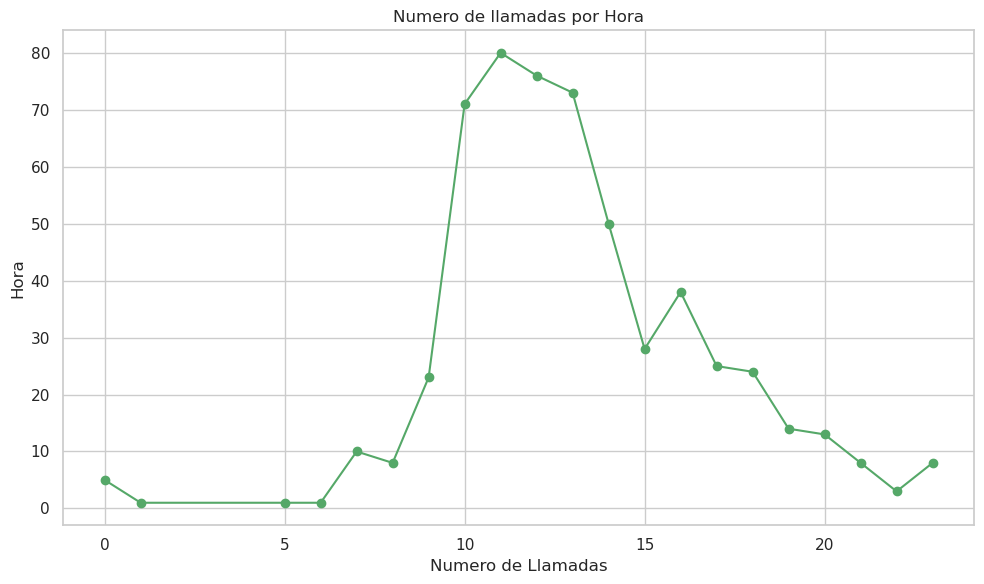

In [53]:
sns.set(style='whitegrid')
sqlstr = """
select  hour(l.hora_solicitud) as hora, avg(l.edad) as edad_promedio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
where year(fecha_solicitud) = 2019 and s.D_mnpio = "Milpa Alta"
group by hora
order by hora 
"""
df_pandas = spark.sql(sqlstr).toPandas()
plt.figure(figsize = (10, 6))
plt.plot(df_pandas['hora'], df_pandas['nr'], marker = 'o', linestyle = '-', color = 'g')

plt.title('Numero de llamadas por Hora')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Hora')
plt.tight_layout()
plt.show()

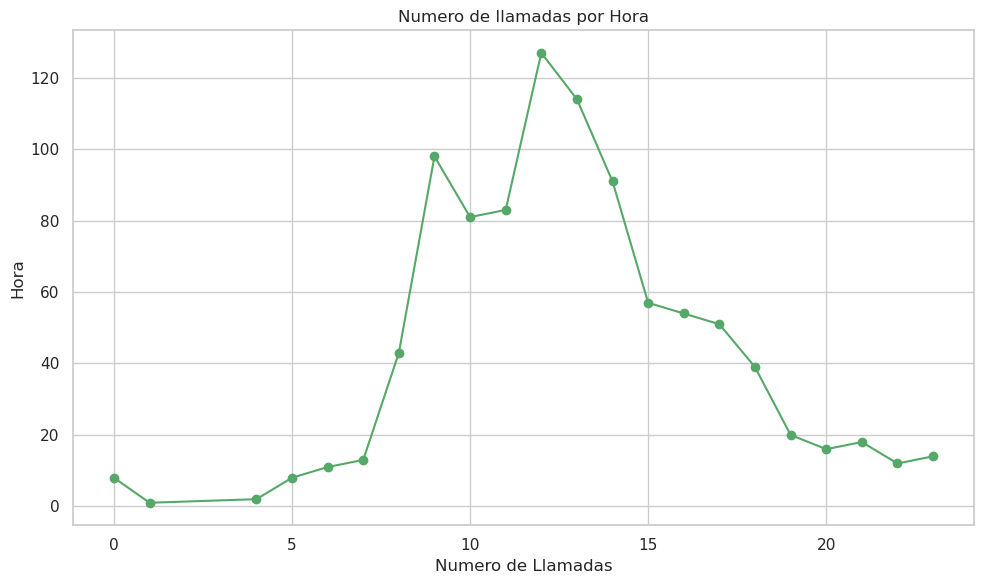

In [57]:
sns.set(style='whitegrid')
sqlstr = """
select  hour(l.hora_solicitud) as hora, avg(l.edad) as edad_promedio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
where year(fecha_solicitud) = 2024 and s.D_mnpio = "Milpa Alta"
group by hora
order by hora 
"""
df_pandas = spark.sql(sqlstr).toPandas()
plt.figure(figsize = (10, 6))
plt.plot(df_pandas['hora'], df_pandas['nr'], marker = 'o', linestyle = '-', color = 'g')

plt.title('Numero de llamadas por Hora (2024, Milpa Alta)')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Hora')
plt.tight_layout()
plt.show()

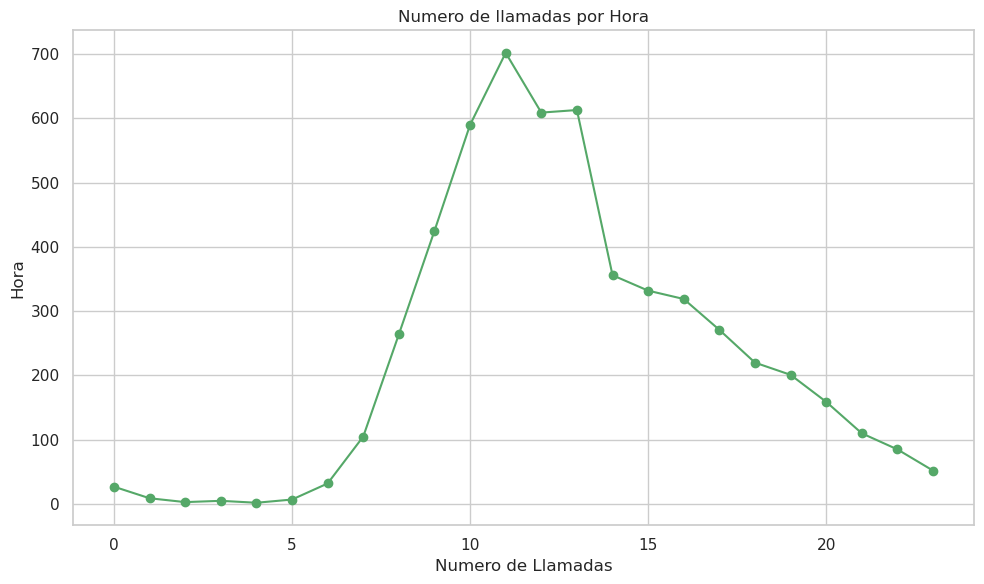

In [58]:
sns.set(style='whitegrid')
sqlstr = """
select  hour(l.hora_solicitud) as hora, avg(l.edad) as edad_promedio,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
where year(fecha_solicitud) = 2023 and s.D_mnpio = "Milpa Alta"
group by hora
order by hora 
"""
df_pandas = spark.sql(sqlstr).toPandas()
plt.figure(figsize = (10, 6))
plt.plot(df_pandas['hora'], df_pandas['nr'], marker = 'o', linestyle = '-', color = 'g')

plt.title('Numero de llamadas por Hora (2023, Milpa Alta)')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Hora')
plt.tight_layout()
plt.show()

In [61]:
sqlstr = """
select l.tema_solicitud,
count(*) as nr
from locatel l
join sepomex s on (l.d_codigo = s.d_codigo)
group by l.tema_solicitud
order by l.tema_solicitud 
"""
df_pandas = spark.sql(sqlstr).toPandas()
df_pandas

,tema_solicitud,nr
0,AGUA POTABLE Y SERVICIOS HIDRÁULICOS,15575
1,ALARMAS VECINALES,1363
2,ALERTA SISMICA,39361
3,ALUMBRADO,243884
4,ANUNCIOS,643
...,...,...
75,VEHÍCULOS AUTOMOTORES Y TAXIS,8867
76,VENTA DE ALCOHOL / DROGA,10340
77,VERIFICACIONES,3152
78,VERIFICACIÓN ADMINISTRATIVA,38841


In [64]:
sqlstr = """
select case when num_reg < 5000 then 'Otros' else tema_solicitud end tema,
sum(num_reg) nr
from(
    select l.tema_solicitud,
    count(*) as num_reg
    from locatel l
    join sepomex s on (l.d_codigo = s.d_codigo)
    group by l.tema_solicitud
    ) x
group by tema
order by nr desc
"""
df_pandas = spark.sql(sqlstr).toPandas()
df_pandas

,tema,nr
0,ALUMBRADO,243884
1,OTRO,235078
2,PODA / RETIRO ARBOL,202817
3,FALTA DE AGUA,197091
4,FUGA DE AGUA,101251
5,BACHEO,90232
6,DESAZOLVE,89554
7,MANTENIMIENTO VÍA PÚBLICA,89194
8,"RETIRO CASCAJO, ESCOMBRO, AZOLVE, RAMAS",69391
9,Otros,67022


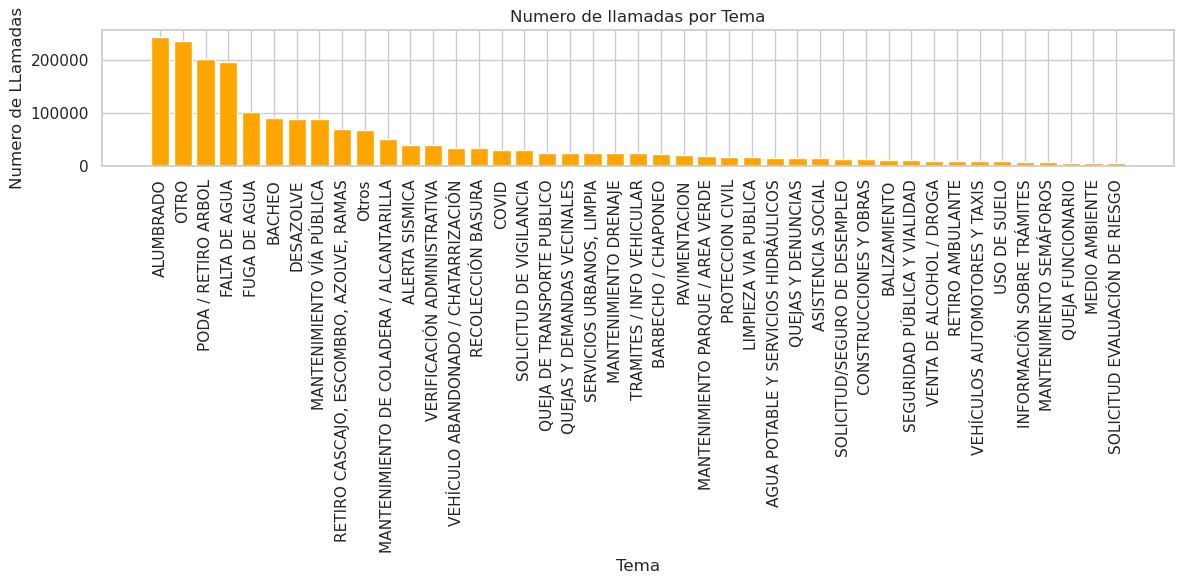

In [65]:
plt.figure(figsize = (12, 6))
plt.bar(df_pandas['tema'], df_pandas['nr'], color = 'orange')
plt.xticks(rotation=90)

plt.title('Numero de llamadas por Tema')
plt.xlabel('Tema')
plt.ylabel('Numero de LLamadas')
plt.tight_layout()
plt.show()